## Basic Setup

- Mounting the drive
- Defining the Environment variables
- Defining the imports

**First we will mount the google Drive**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define all our imports**

In [3]:
import math
import random
import scipy.io as scio
import numpy as np
import scipy.ndimage as scnd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

**Define all the Environment Variables**

In [4]:
DATASET_PATH = '/content/drive/My Drive/datasets/indian_pines/'
NUM_X = 145
NUM_Y = 145
IMG_SIZE = 130*130
CLASSES = 16
BANDS = 200
FREQ = np.array([0.5,0.25,0.125,0.0625])
NUM_FREQ = (FREQ.shape)[0]
SEGMENT_SIZES = np.array([50,100,150,200,250,300,350,400,450,500]) # In steps of 50

## Data Loading and preprocessing

- Load the data
- Display HSI bands
- Scale the data using the standard zero mean scaler
- Get a Matrix of train_test_split for sampling training data

**Load the Indian Pines Dataset and do some pre-processing**

In [ ]:
nonscaled_data = scio.loadmat(DATASET_PATH + 'Indian_pines_corrected.mat').get('indian_pines_corrected')
corrected_pines = scio.loadmat(DATASET_PATH + 'Indian_pines_corrected.mat')
corrected_pines = np.array(corrected_pines.get('indian_pines_corrected'))

gt = scio.loadmat(DATASET_PATH + 'Indian_pines_gt.mat')
gt = np.array(gt.get('indian_pines_gt'))

**Different Bands of HSI**

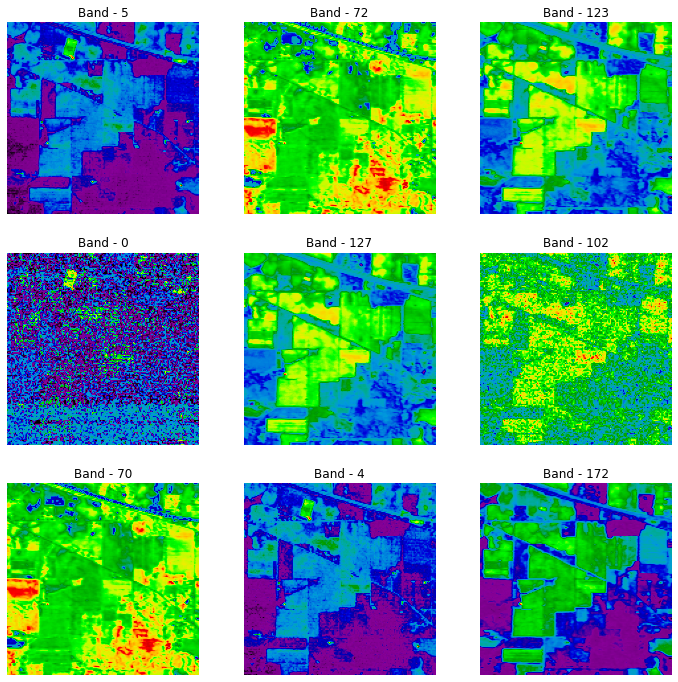

In [ ]:
fig = plt.figure(figsize = (12, 12))

for i in range(1, 1+9):
    fig.add_subplot(3,3, i)
    band = np.random.randint(nonscaled_data.shape[2])
    plt.imshow(nonscaled_data[:,:,band], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {band}')

**Class Label Distribution**

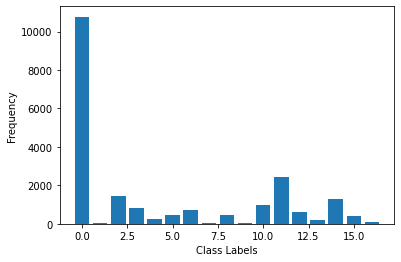

In [ ]:
hash = {}
for i in range(145):
  for j in range(145):
    if hash.get(gt[i, j]) is None:
      hash[gt[i, j]] = 1
    else:
      hash[gt[i, j]] = hash[gt[i, j]] + 1

x = []
y = []
for key in sorted(hash):
  x.append(int(key))
  y.append(int(hash[key]))

plt.bar(x,y,align='center') # A bar chart
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def scale_data(corrected_pines):
  scaled_data = np.zeros((NUM_X, NUM_Y, BANDS))
  for i in range(NUM_X):
    for j in range(NUM_Y):
      mn = 0
      sd = 0
      for k in range(BANDS):
        mn += corrected_pines[i][j][k]
      mn/=BANDS

      for k in range(BANDS):
        sd += ((corrected_pines[i][j][k] - mn)**2)
      sd/=BANDS
      sd = math.sqrt(sd)

      for k in range(BANDS):
        sd += ((corrected_pines[i][j][k] - mn)**2)
      sd/=BANDS
      sd = math.sqrt(sd)

      for k in range(BANDS):  
        scaled_data[i][j][k] = (corrected_pines[i][j][k] - mn)/sd
  
  return scaled_data

In [ ]:
print("DataSet before scaling:")
print(corrected_pines[0][0])
corrected_pines = scale_data(corrected_pines)
print("DataSet after scaling:")
print(corrected_pines[0][0])

DataSet before scaling:
[3172 4142 4506 4279 4782 5048 5213 5106 5053 4750 4816 4769 4610 4805
 4828 4861 4767 4624 4549 4463 4462 4446 4445 4336 4381 4319 4207 4305
 4311 3991 4168 3942 4061 4362 4318 4252 4869 5284 5055 3591 5175 5217
 5058 4969 4721 4291 4555 4886 4868 4806 4783 4811 4709 3903 3795 3715
 2591 2130 2269 2480 3145 3626 4060 4296 4211 4225 4157 4133 4082 4048
 3935 3843 3784 3642 3271 2707 1707 1564 1838 1719 2229 2764 2919 2873
 2977 2913 3034 3051 3124 3101 3033 2713 2740 2947 2706 2834 2856 2683
 2400 2229 1822 1542 1097 1047 1069 1100 1122 1259 1365 1261 1374 1630
 1851 2028 2130 2170 2205 2214 2204 2100 2106 2146 2089 2078 2134 2127
 2074 2057 2045 2003 1999 1959 1924 1883 1843 1781 1716 1698 1645 1540
 1410 1294 1131 1044 1032 1045 1100 1212 1295 1244 1100 1103 1216 1346
 1330 1259 1251 1313 1372 1393 1402 1396 1381 1396 1381 1353 1346 1341
 1332 1324 1310 1318 1330 1310 1292 1280 1275 1266 1264 1233 1241 1232
 1215 1215 1187 1168 1171 1150 1134 1123 1135 1094 10

**Train Test Split**

In [ ]:
def get_train_test_idx(gt):

  train_test_set = np.zeros(gt.shape)

  samples_per_class = 15
  pixel_to_class_map = [[] for x in range(CLASSES)]
  training_class_list = [[] for x in range(CLASSES)]
  for c in range(CLASSES):
    num_samples = 0
    for i in range(NUM_X):
      for j in range(NUM_Y):
        if(gt[i][j] == c):
          num_samples += 1
          pixel_to_class_map[c].append((i,j))
    
    class_list = random.sample(pixel_to_class_map[c], int(samples_per_class))
    training_class_list[c] = class_list
    for (x,y) in class_list:
      train_test_set[x][y] = 1  

  return (train_test_set,training_class_list)


In [ ]:
train_test_set,training_class_list = get_train_test_idx(gt)
print(train_test_set)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**PCA on corrected_pines**

In [ ]:
d2_pines = corrected_pines.reshape(-1, corrected_pines.shape[2])

pca = PCA(n_components = 3)
pca_pines = pca.fit_transform(d2_pines)

maxx = pca_pines.max()
minn = pca_pines.min()
for i in range(pca_pines.shape[0]):
  for j in range(pca_pines.shape[1]):
    pca_pines[i, j] = (pca_pines[i, j] - minn)/(maxx - minn)
  
print(pca_pines.shape)

reshaped_pca_pines = np.reshape(pca_pines, (145, 145, 3))
print(reshaped_pca_pines.shape)

(21025, 3)
(145, 145, 3)


**PCA Image**

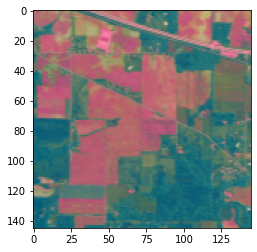

In [ ]:
plt.imshow(reshaped_pca_pines)

## Gabor 3D Filter building

- Here we will define the functions that will create the 3D Gabor Filter for the real part and the imaginary part, since it is a complex filter
- Then we will create 4 filters(each with one real and one imaginary part) using 4 different frequency values = [0.5, 0.25, 0.125, 0.0625]

In [ ]:
def real_gabor_fn(freq, sigma=4.0, phase=0.0, size=5, psi=0.0):
    coordinates = np.arange(-size, size + 1)
    (z, y, x) = np.meshgrid(coordinates, coordinates, coordinates)
    
    const = 1 / float((np.power(sigma, 3) * np.power(2*np.pi, 2/3)))
    gaussian = np.exp(-0.5 * ((x**2 + y**2 + z**2)/sigma))
    gabor_real = const * gaussian * (np.cos(2*np.pi*x*freq + psi))
    return gabor_real

**3D Gabor Filter Bands Plot**

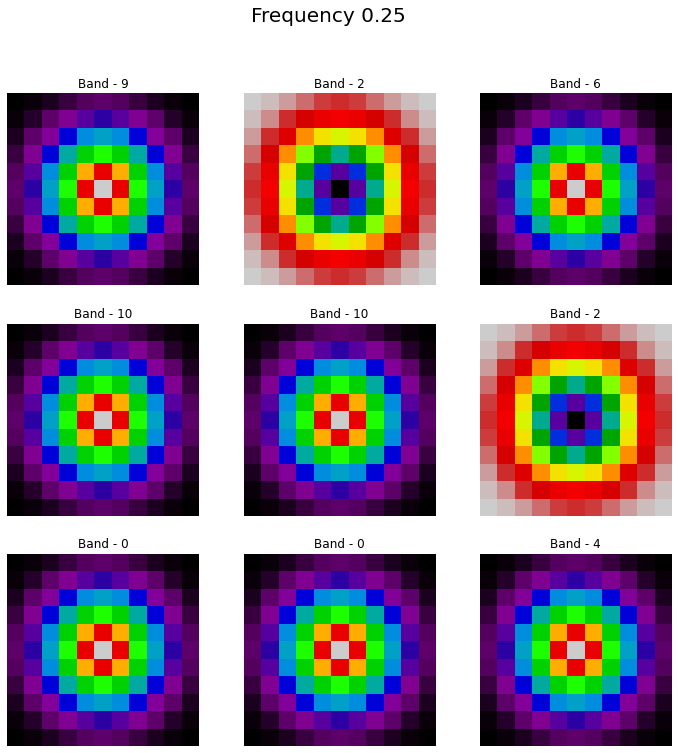

In [ ]:
gb = real_gabor_fn(0.25)

fig = plt.figure(figsize = (12, 12))
fig.suptitle('Frequency 0.25', fontsize=20)
for i in range(1, 1+9):
    fig.add_subplot(3,3, i)
    band = np.random.randint(gb.shape[2])
    plt.imshow(gb[:,:,band], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {band}')

In [ ]:
def img_gabor_fn(freq, sigma=4.0, phase=0.0, size=5, psi=0.0):
    coordinates = np.arange(-size, size + 1)
    (z, y, x) = np.meshgrid(coordinates, coordinates, coordinates)
    
    const = 1 / float((np.power(sigma, 3) * np.power(2*np.pi, 2/3)))
    gaussian = np.exp(-0.5 * ((x**2 + y**2 + z**2)/sigma))
    gabor_img = const * gaussian * (np.sin(2*np.pi*x*freq + psi))
    return gabor_img

**Creating the real and imaginary Filters**

In [ ]:
real_gabor_arr = [real_gabor_fn(x) for x in FREQ]

In [ ]:
img_gabor_arr = [img_gabor_fn(x) for x in FREQ]

## Convolving the images with 3D Gabor Filter

- We will convolve the real and imaginary parts of the 4 Gabor Filters with the Hyperspectral image
- We will then get the Magnitude and Phase features

In [ ]:
real_G_out_arr = np.array([scnd.convolve(corrected_pines, real_gabor_arr[x]) for x in range(NUM_FREQ)])
print(real_G_out_arr.shape)

(4, 145, 145, 200)


**3D Gabor Filter Convolution Bands Plot**

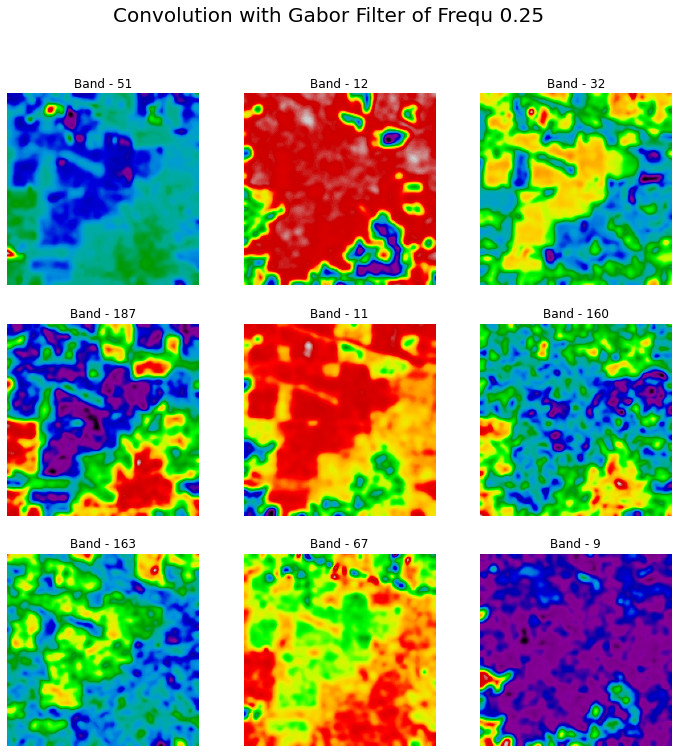

In [ ]:
plot_G_out = real_G_out_arr[1]
maxx = plot_G_out.max()
minn = plot_G_out.min()
for i in range(plot_G_out.shape[0]):
  for j in range(plot_G_out.shape[1]):
    for k in range(plot_G_out.shape[2]):
      plot_G_out[i, j, k] = (plot_G_out[i, j, k] - minn)/(maxx - minn)

fig = plt.figure(figsize = (12, 12))
fig.suptitle('Convolution with Gabor Filter of Frequ 0.25', fontsize=20)
for i in range(1, 1+9):
    fig.add_subplot(3,3, i)
    band = np.random.randint(plot_G_out.shape[2])
    plt.imshow(plot_G_out[:,:,band], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {band}')

In [ ]:
img_G_out_arr = np.array([scnd.convolve(corrected_pines, img_gabor_arr[x]) for x in range(NUM_FREQ)])

In [ ]:
real_sqr = np.array([ np.square(real_G_out_arr[x]) for x in range(NUM_FREQ)])
img_sqr = np.array([ np.square(img_G_out_arr[x]) for x in range(NUM_FREQ)])

# We will use this in the Confidence Cube Calculation
M_feat_arr = np.array([ np.sqrt( real_sqr[x] + img_sqr[x] ) for x in range(NUM_FREQ)]) 

# We don't need the Phase features for now since we will directly use the Real and imaginary part in Hamming Cube

## Confidence Cube Calculation

In this section we will generate the confidence cube that will be used in making the weighing cube

**Building and training the SVMs**

In [ ]:
def build_svm(train_test_set, M_feat_arr, gt, idx):
  svc = SVC(kernel='rbf', decision_function_shape='ovo')
  num_samples = np.count_nonzero(train_test_set == 1)
  ctr = 0
  train_X = np.zeros((num_samples, BANDS))
  train_Y = np.zeros((num_samples))
  for i in range(NUM_X):
    for j in range(NUM_Y):
      if(train_test_set[i][j] == 1):
        train_X[ctr] = nonscaled_data[i][j] # M_feat_arr[idx][i][j]
        train_Y[ctr] = gt[i][j]
        ctr+=1
  svc.fit(train_X, train_Y)
  return svc

In [ ]:
svc_arr = np.array([build_svm(train_test_set, M_feat_arr, gt, x) for x in range(NUM_FREQ)])

In [ ]:
def test_svm(train_test_set, M_feat_arr, gt, idx, svc):
  num_samples = NUM_X*NUM_Y - np.count_nonzero(train_test_set == 1)
  ctr = 0
  test_X = np.zeros((num_samples, BANDS))
  test_Y = np.zeros((num_samples))
  for i in range(NUM_X):
    for j in range(NUM_Y):
      if(train_test_set[i][j] == 0):
        test_X[ctr] = nonscaled_data[i][j]
        test_Y[ctr] = gt[i][j]
        ctr+=1
  acc = svc.score(test_X, test_Y)
  return acc

In [ ]:
test_svm(train_test_set, M_feat_arr, gt, 0, svc_arr[0])

0.2497955256194371

**Confidence Cube creation using Decision Matrix**

In [ ]:
def get_decision_matrix(decision_fn_res):

    decision_matrix = np.zeros((CLASSES, CLASSES))
    counter = 0
    for i in range(0,CLASSES):
        for j in range(i+1, CLASSES):
            decision_matrix[i][j] = abs(decision_fn_res[0][counter])
            decision_matrix[j][i] = abs(decision_fn_res[0][counter])
            counter+=1

    return decision_matrix

In [ ]:
def get_confidence_score(decision_matrix, cls):
  nc_arr = np.count_nonzero(decision_matrix != 0, axis = 1) # axis=1 gives the count per row.
  nc = nc_arr[cls]
  score = 0
  val = 0
  for i in range(NUM_FREQ):
    for j in range(CLASSES):
      val += decision_matrix[cls][j]
    val = val/(2*nc)
    score = val + (math.sqrt(nc)/(2 * CLASSES))
  return score

In [ ]:
def get_confidence_cube():
  confidence_cube_arr = np.zeros((NUM_FREQ,NUM_X,NUM_Y,CLASSES))
  for i in range(0,NUM_FREQ):
    svc = svc_arr[i]

    ctr = 0
    num_samples = NUM_X*NUM_Y
    test_X = np.zeros((num_samples, BANDS))
    test_Y = np.zeros((num_samples))
    for j in range(NUM_X):
      for k in range(NUM_Y):
        if(train_test_set[i][j] == 0):
          test_X[ctr] = M_feat_arr[i][j][k]
          test_Y[ctr] = gt[j][k]
          ctr+=1
    ctr = 0
    for j in range(0,NUM_X):
      for k in range(0,NUM_Y):
        decision_fn_res = svc.decision_function(np.array([test_X[ctr]])) # For a single Pixel
        decision_matrix = get_decision_matrix(decision_fn_res)
        ctr+=1
        for c in range(0,CLASSES):
          confidence_cube_arr[i][j][k][c] = get_confidence_score(decision_matrix, c)

  return confidence_cube_arr

In [ ]:
confidence_cube_arr = get_confidence_cube()
print(confidence_cube_arr[0][0][0])

[0.20773615 0.20243592 0.18665321 0.18424264 0.23160785 0.20572913
 0.20208322 0.19560379 0.1926554  0.18373    0.19093504 0.180512
 0.25659167 0.20528639 0.1863792  0.16679801]


## Hamming Cube Calculation

This section carries out the process of building the Hamming Cube

In [ ]:
def hamming_distance(Re_pp, Img_pp, Re_qq, Img_qq):
  h = 0.0
  for z in range(BANDS):
    h += (int(Re_pp[z])^int(Re_qq[z]) + int(Img_pp[z])^int(Img_qq[z]))
  h /= (2*BANDS)
  return h

In [ ]:
def build_Q_real_img():
  quadrant = np.zeros((NUM_FREQ,4 + 1))
  Q_real = np.zeros((NUM_FREQ, NUM_X, NUM_Y, BANDS))
  Q_img = np.zeros((NUM_FREQ, NUM_X, NUM_Y, BANDS))
  for val in range(NUM_FREQ):
    real_G_out = real_G_out_arr[val]
    img_G_out = img_G_out_arr[val]
    for i in range(NUM_X):
      for j in range(NUM_Y):
        for k in range(BANDS):
          if img_G_out[i, j, k] >=0 and real_G_out[i, j, k]>=0:
            # I Quadrant
            Q_real[val, i, j, k] = 1
            Q_img[val, i, j, k] = 1
            quadrant[val][0] = 1
          elif img_G_out[i, j, k] <0 and real_G_out[i, j, k]>=0:
            # II Quadrant
            Q_real[val, i, j, k] = 0
            Q_img[val, i, j, k] = 1
            quadrant[val][1] = 1
          elif img_G_out[i, j, k] <0 and real_G_out[i, j, k]<0:
            # III Quadrant
            Q_real[val, i, j, k] = 0
            Q_img[val, i, j, k] = 0
            quadrant[val][2] = 1
          elif img_G_out[i, j, k] >=0 and real_G_out[i, j, k]<0:
            # IV Quadrant
            Q_real[val, i, j, k] = 1
            Q_img[val, i, j, k] = 0
            quadrant[val][3] = 1
          else:
            print(angle)
            quadrant[val][4] = 1

  print(quadrant)
  return (Q_real, Q_img)

In [ ]:
(Q_real_arr, Q_img_arr) = build_Q_real_img()

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]]


In [ ]:
def get_hamming_cube():
  hamming_dist_arr = np.zeros((NUM_FREQ, NUM_X, NUM_Y, CLASSES))
  for val in range(NUM_FREQ):
    Q_real = Q_real_arr[val]
    Q_img = Q_img_arr[val]
    for i in range(NUM_X):
      for j in range(NUM_Y):
        Re_pp = Q_real[i, j]
        Img_pp = Q_img[i, j]
        for c in range(CLASSES):
          h_min = 1.0
          for (x,y) in training_class_list[c]:
            Re_qq = Q_real[x, y]
            Img_qq = Q_img[x, y]
            h_min = min(h_min, hamming_distance(Re_pp, Img_pp, Re_qq, Img_qq))
          hamming_dist_arr[val, i, j, c] = h_min
  return hamming_dist_arr

In [ ]:
hamming_cube_arr = get_hamming_cube()

## Weighing Cube formation

- In this section we will build the weighing cube from the Hamming Cube and the Confidence Cube created above
- We will use the Weighing Cube in Cascade superpixel regularization

In [ ]:
def get_weighing_cube(C,H):
  W = np.zeros((NUM_X, NUM_Y, CLASSES))
  for i in range(NUM_FREQ):
    W += C[i] - H[i]
  return W

In [ ]:
weighing_cube = get_weighing_cube(confidence_cube_arr, hamming_cube_arr)

[[[-1.29157536 -1.3227936  -1.32090545 ... -1.26891453 -1.47700694
   -1.45782027]
  [-1.29157536 -1.3227936  -1.32590545 ... -1.26891451 -1.47700695
   -1.45782028]
  [-1.29657537 -1.3277936  -1.32340546 ... -1.26891446 -1.48700696
   -1.46282028]
  ...
  [-1.31657558 -1.34029426 -1.36090559 ... -1.3014158  -1.50200719
   -1.48282038]
  [-1.30907562 -1.32779433 -1.35340562 ... -1.29391584 -1.49450725
   -1.4753204 ]
  [-1.30907563 -1.32779436 -1.35340564 ... -1.29391583 -1.49450729
   -1.4753204 ]]

 [[-1.29657534 -1.3227936  -1.32090543 ... -1.26891455 -1.48200692
   -1.45782027]
  [-1.28907535 -1.32029359 -1.32340544 ... -1.26641451 -1.47450693
   -1.45532027]
  [-1.29157535 -1.32279358 -1.31590545 ... -1.26391444 -1.48200694
   -1.45782027]
  ...
  [-1.31407554 -1.33779419 -1.35340555 ... -1.29891569 -1.49950714
   -1.48032036]
  [-1.31657558 -1.33529425 -1.35590558 ... -1.30141572 -1.4970072
   -1.48282037]
  [-1.31657559 -1.33529428 -1.3609056  ... -1.3014157  -1.50200723
   -1.4

## Cascade SuperPixel Regularization

- Here we will first get the superpixel graphs using Entropy rate superpixel
- Then we will apply regularization algorithm

In [ ]:
def superpixel_slic(segment_sizes=SEGMENT_SIZES, show_plot=False):

  segment_arr = []
  for numSegments in segment_sizes:
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(reshaped_pca_pines, n_segments = numSegments, sigma = 5)
    segment_arr.append(segments)
    if(show_plot):
    # show the output of SLIC
      fig = plt.figure("Superpixels -- %d segments" % (numSegments))
      ax = fig.add_subplot(1, 1, 1)
      ax.imshow(mark_boundaries(reshaped_pca_pines, segments))
      plt.axis("off")
  # show the plots
  if(show_plot):
    plt.show()
  return segment_arr

In [ ]:
def get_s_graph(segments, nC):
  s_graph = [[] for x in range(nC)]

  for i in range(NUM_X):
    for j in range(NUM_Y):
      try:
        s_graph[segments[i][j]].append((i,j))
      except:
        print("err")
        print(segments[i][j])
        print(nC)
  return s_graph

  

In [ ]:
def SR(gt, train_test_set, s_graph, W, K):
  U = np.zeros((NUM_X, NUM_Y, CLASSES))
  for i in range(K):
    sk = s_graph[i]
    num_common_samples = 0
    common_samples = []

    # Num of common samples
    for (x,y) in sk:
      if(train_test_set[x][y] == 1):
          num_common_samples += 1
          common_samples.append((x,y))
    
    if(num_common_samples == 1):
      u = np.zeros((CLASSES))
      c = gt[common_samples[0][0]][common_samples[0][1]]
      u[c] = 1

      for (x,y) in sk:
        U[x][y] = u
    else:
      mn = 0
      num_samples = 0
      for (x,y) in sk:
        num_samples += 1
        for c in range(CLASSES):
          mn += W[x][y][c]

        mn = mn/CLASSES
        U[x][y] = np.array([mn/num_samples for x in range(CLASSES)])

  
  return U


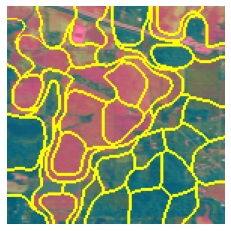

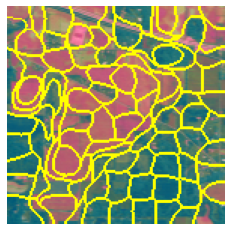

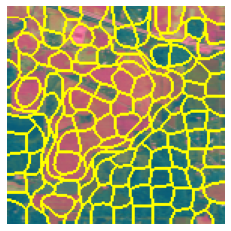

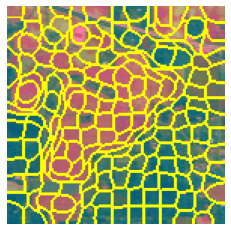

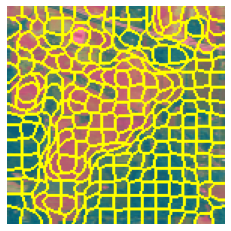

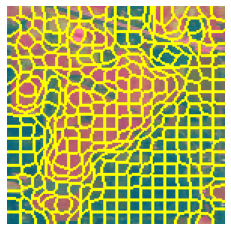

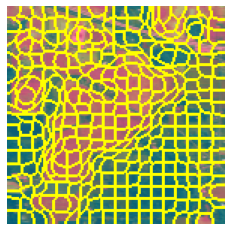

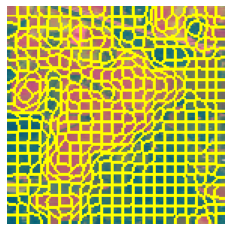

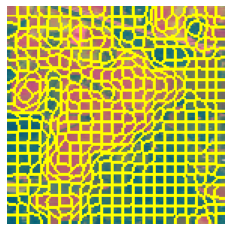

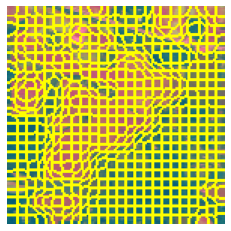

In [ ]:
Z = np.zeros((NUM_X, NUM_Y, CLASSES))
segment_arr = superpixel_slic(SEGMENT_SIZES, True)
for i in range(len(segment_arr)):

  mx = np.max(segment_arr[i])
  s_graph = get_s_graph(segment_arr[i], mx+1)
  Z += SR(gt, train_test_set, s_graph, weighing_cube, mx+1)

## Classification

- Based on the generated Weight cube from superpixel regularization (Z), we can carry out the classification task
- We will simply pick the class with the max weight as the predicted class of the pixel

In [ ]:
predicted_classes = np.zeros((NUM_X, NUM_Y))
for i in range(NUM_X):
  for j in range(NUM_Y):
    predicted_classes[i][j] = np.argmax(Z[i][j])

num_true = 0
for i in range(NUM_X):
  for j in range(NUM_Y):
    if(gt[i][j] == predicted_classes[i][j]):
      num_true+=1

print(num_true/IMG_SIZE)

0.7979881656804734


## Results and Graphs

- The HSI dataset has been segmented using two methods:

1.   Entropy Rate superpixel (ERS) segmentation which is implemented in this paper. 
2.   Slic which is a built in library in python.

- The results from both the methods have been compared and the method implemented in this paper performs better than the slic.


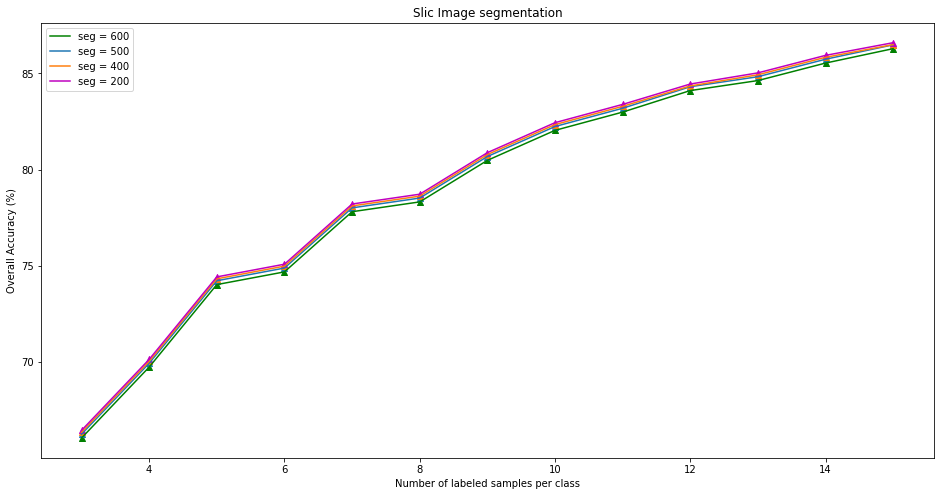

<Figure size 1152x576 with 0 Axes>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

slic_results = pd.read_csv(DATASET_PATH + 'results_slic.csv', sep=',')

x = slic_results['x'].to_list()
y0 = slic_results['y0'].to_list()
y1 = slic_results['y1'].to_list()
y2 = slic_results['y2'].to_list()
y3 = slic_results['y3'].to_list()

figsize(16, 8)
plt.plot(x, y0, label = r"seg = %d" % 600, color="g")
plt.plot(x, y1, label = r"seg = %d" % 500)
plt.plot(x, y2, label = r"seg = %d" % 400)
plt.plot(x, y3, label = r"seg = %d" % 200, color="m")
plt.scatter(x, y0, marker='^', color="g")
plt.scatter(x, y1, marker='^')
plt.scatter(x, y2, marker='^')
plt.scatter(x, y3, marker='^', color="m")
plt.xlabel('Number of labeled samples per class')
plt.ylabel('Overall Accuracy (%)')
plt.title("Slic Image segmentation")
plt.plot()
plt.legend()
plt.show()
plt.savefig('slic.png')